<a href="https://colab.research.google.com/github/WilliamNwoke/modeling-autism-in-adults/blob/main/Modelling_autism_in_adults.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Modelling Autism Spectrum Disorder in Adults** <br>
Nicholas McNamara, Uchenna Nwoke, Sai Sreyas

**Project_Part_4_Team_5**

Our goal is to create a model that accurately predicts Autism Spectrum Disorder (ASD) in
Adults, and determines which of our features are the greatest predictor of being on the spectrum.<br>
- [Description of Dataset](https://(https://www.kaggle.com/competitions/autismdiagnosis/data)
- We will first import our environment and datasets, then clean our data and preform some basic analysis.
- We will create a linear regression model using the AQ10 *result* to determine its efficacy at predicting autism. We will then try to see if there is any correlation between the test results, a persons age, and if this helps correct results.
- We will then create a decision tree to determine the most important categorical features to use in future supervised learning models.



In [96]:
#Import libraries used:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm
import missingno as msno
import seaborn as sns
from google.colab import drive
import statistics as stats
import sklearn
from sklearn import linear_model

# Select a linear model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

# Imports for Clustering
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform, pdist
from imblearn.under_sampling import RandomUnderSampler
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift
from scipy.stats import entropy

# Imports for Classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
# Load files from shared google drive:
test_data = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vSwZecEO8vZvJJPPllpn3UjsAin9o_5PPJnnrDH4P1nY6J9Nz3jTPcmWKCNjXNQtCqZPVyiPz62fO0p/pub?gid=994124369&single=true&output=csv")
train_data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTF-RQWZBDXs14DzRnlporYQGNp5dxXj8pc-ihhwVvdrIUoZOeKPN8bO9rtDM0F5zmViSpn-XRYB1S_/pub?gid=987980573&single=true&output=csv')


## Data Preparation:
Lets begin by examining our dataset:

In [97]:
print("Our Training Database:")
print("Dimmensions: " + str(train_data.shape))
print(train_data.info())
print("\nOur Test Database:")
print("Dimmensions: " + str(test_data.shape))
print(test_data.info())
print(train_data['Class/ASD'].value_counts())

Our Training Database:
Dimmensions: (800, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    object 
 13  ethnicity        800 non-null    object 
 14  jaundice         800 non-null    object 
 15  austim           800 non-null    object 
 16  contry_of_res   

- The two datasets have the same columns, with train_data having an extra column labelled "Class/ASD". The training data has 800 entries, while the test data has 200. <br><br>
- *Class/ASD* wil be our target feature. This variable is the class label determining if a person has been diagnosed with autism.<br><br>
- Lets begin by removing the ID column from both datasets, since its a redundant index:




In [98]:
# Remove ID columns:
test_data = test_data.drop(columns = ['ID'])
train_data = train_data.drop(columns = ['ID'])

- We next need to combine the AQ scores into a single numeric column for both datasets:

In [99]:
# Create AQ_SCore variable:
test_data["AQ10_Sentiment"] = 0 # Ensures that if the cell is reran, the sum isn't recalculated
train_data["AQ10_Sentiment"] = 0 # Ensures that if the cell is reran, the sum isn't recalculated
aq = train_data.columns[:9]
train_data["AQ10_Sentiment"] = train_data[aq].sum(axis=1)
test_data["AQ10_Sentiment"] = test_data[aq].sum(axis=1)
print("Lets look at this new column and verify it hold integer values:")
print(test_data["AQ10_Sentiment"].head())
print(test_data['age'].head())

Lets look at this new column and verify it hold integer values:
0    5
1    2
2    7
3    0
4    1
Name: AQ10_Sentiment, dtype: int64
0    15.599481
1    27.181099
2    31.643906
3    25.369210
4     9.078580
Name: age, dtype: float64


- The column austim not only has a typo, but isn't very descriptive. It is supposed to denote whether a relative has autism or not, so lets rename the column to be less confusing.

In [100]:
# Rename columns to correct typo and clear confusion
train_data.rename(columns = {'austim':'relative_has_autism'}, inplace = True)
test_data.rename(columns = {'austim':'relative_has_autism'}, inplace = True)
train_data.rename(columns = {'contry_of_res':'country_of_res'}, inplace = True)
test_data.rename(columns = {'contry_of_res':'country_of_res'}, inplace = True)

- We have several categorical columns that have binary values: gender, jaundice, used_app_before, relative_has_autism. Lets change these to binary numerical columns for use in numerical analysis:

In [101]:
# First change gender for train/test datasets
train_data['gender'] = train_data['gender'].map({'m': 0, 'f': 1})
test_data['gender'] = test_data['gender'].map({'m': 0, 'f': 1})
print(train_data['gender'].head())
cols_to_change = ['jaundice', 'used_app_before', 'relative_has_autism']
for col in cols_to_change:
  train_data[col] = train_data[col].map({'no': 0, 'yes': 1})
  test_data[col] = test_data[col].map({'no': 0, 'yes': 1})

print(train_data[cols_to_change].head())

0    1
1    0
2    0
3    1
4    0
Name: gender, dtype: int64
   jaundice  used_app_before  relative_has_autism
0         0                0                    0
1         0                0                    0
2         0                0                    1
3         0                0                    0
4         0                0                    0


## Data Cleaning and Analysis:
- Lets begin by examining possible missing values within the training dataset:

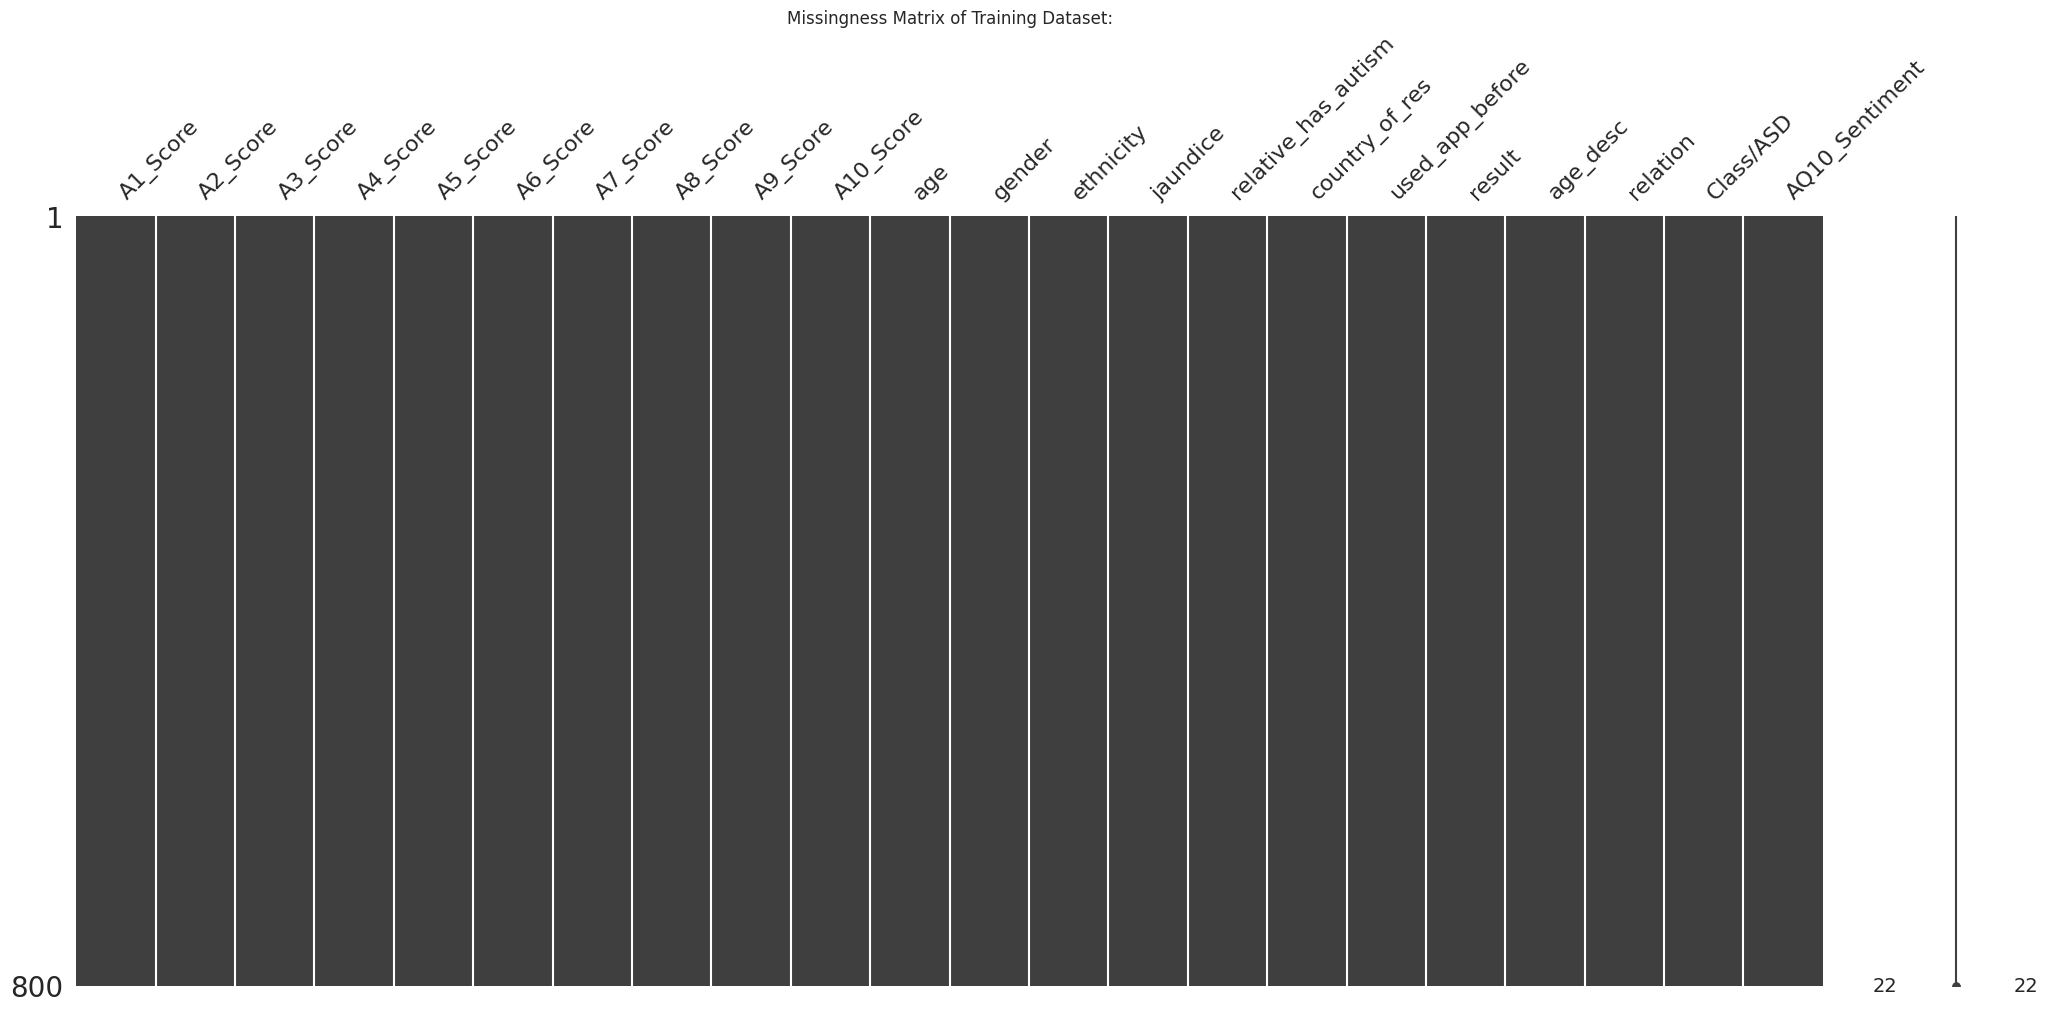

In [102]:
msno.matrix(train_data)
plt.title("Missingness Matrix of Training Dataset:")
plt.show()

- There are no outright unfilled values within our dataset.<br><br>
- Next we will check for misplaced zero entries or ? entries:

In [103]:
column_zeros = train_data.eq(0).sum()
print("Column:  zero count:")
print(column_zeros)
print("\nColumn:  '?' count:")
column_unknowns = train_data.eq('?').sum()
print(column_unknowns)

Column:  zero count:
A1_Score               352
A2_Score               376
A3_Score               440
A4_Score               468
A5_Score               484
A6_Score               557
A7_Score               482
A8_Score               393
A9_Score               404
A10_Score              306
age                      0
gender                 530
ethnicity                0
jaundice               615
relative_has_autism    669
country_of_res           0
used_app_before        750
result                   0
age_desc                 0
relation                 0
Class/ASD              639
AQ10_Sentiment         128
dtype: int64

Column:  '?' count:
A1_Score                 0
A2_Score                 0
A3_Score                 0
A4_Score                 0
A5_Score                 0
A6_Score                 0
A7_Score                 0
A8_Score                 0
A9_Score                 0
A10_Score                0
age                      0
gender                   0
ethnicity              203


- our A#_Score variables are either binary or a summation of binary rows. Therefore zero values are expected and welcomed.
- gender, jaundice, relative_has_autism, and used_app_before are all binary, so zeros are expected.
- Our other numeric columns: age and result have no zero values, so they won't be an issue for this dataset.
<br><br>
- Two categorical variables have '?' values:
  - The relation feature only has 40 missing values. This variable records who filled in the AQ test. Since there is a relatively small number of '?' entries, we will replace them with the most frequently occuring label "self".
  - the ethnicity feature has a significant number of '?' entries. Since the entry "Others" is already present in the dataset, we will continue using this convention and replace our "?" variables with "Other".



In [104]:
# Since most of the data filled by self
def replace_questions(df):
  df['relation'] = np.where(df['relation'] == '?', 'Others', df['relation'])
  # using "others" as its own category for replacing ?.
  df['ethnicity'] = np.where(df['ethnicity'] == '?', 'Others', df['ethnicity'])
  df['ethnicity'] = np.where(df['ethnicity'] == 'others', 'Others', df['ethnicity'])

replace_questions(train_data)
replace_questions(test_data)

- We want to examine our categorical columns and their relation to ASD:

<Figure size 1400x1000 with 0 Axes>

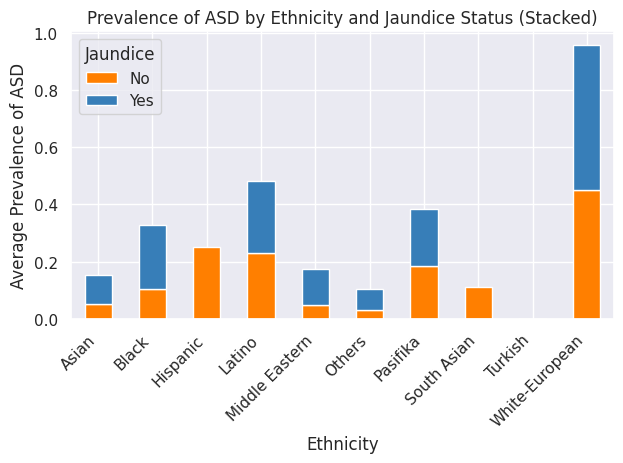

In [105]:
# Boxplot for categorical columns
asd_by_ethnicity_jaundice_stacked = train_data.groupby(['ethnicity', 'jaundice'])['Class/ASD'].mean().unstack()

# Plotting the stacked bar chart
plt.figure(figsize=(14, 10))
asd_by_ethnicity_jaundice_stacked.plot(kind='bar', stacked=True, color=['#ff7f00', '#377eb8'])
plt.title('Prevalence of ASD by Ethnicity and Jaundice Status (Stacked)')
plt.ylabel('Average Prevalence of ASD')
plt.xlabel('Ethnicity')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Jaundice', labels=['No', 'Yes'])
plt.tight_layout()

plt.show()

* The bar chart above shows the prevalence of ASD by ethnicity, further segmented by jaundice status ("Yes" for presence and "No" for absence). Each pair of bars for an ethnicity represents the proportion of individuals with ASD within the groups of those with and without jaundice.

* This visualization enables a comparison within each ethnic group to see if there's a noticeable difference in ASD prevalence associated with the presence of jaundice. It provides insights into whether jaundice could be a factor related to ASD across different ethnic backgrounds

<Figure size 1200x800 with 0 Axes>

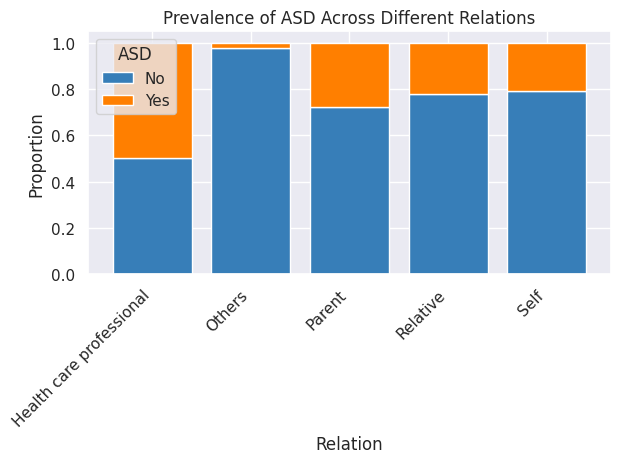

In [106]:
asd_by_relations = train_data.groupby('relation')['Class/ASD'].value_counts(normalize=True).unstack()

# Plotting for 'relations'
plt.figure(figsize=(12, 8))
asd_by_relations.plot(kind='bar', stacked=True, color=['#377eb8', '#ff7f00'], width=0.8)
plt.title('Prevalence of ASD Across Different Relations')
plt.ylabel('Proportion')
plt.xlabel('Relation')
plt.xticks(rotation=45, ha='right')
plt.legend(title='ASD', labels=['No', 'Yes'])
plt.tight_layout()

plt.show()

* The bar chart above illustrates the prevalence of ASD across different types of relations, with each bar segmented into proportions representing individuals with and without ASD. This visualization enables a comparison of ASD rates across various relationship categories, highlighting any differences in prevalence that may exist based on the reported relationship of the respondent to the individual with ASD (e.g., self, parent, relative, health care professional).

- Since the Relation variable directly relates to the efficacy of teh AQ10 test and therefore results, lets split this column into 3 binary columns:
  - Relative, parent, and Self have very similar proportions, we will group these into the single binary variable relation_direct.
  - 'Health care professional' will be represented by the binary variable relation_health_professional - 'Others' will be represented  by relation_other

In [107]:
# This function does the work of combining variables so we don't have to do it twice.
def combine_values_of_relation_column(df):
  df.loc[(df['relation'] == 'Parent'), 'relation'] = 'relation_direct'
  df.loc[(df['relation'] == 'Relative'),  'relation'] = 'relation_direct'
  df.loc[(df['relation'] == 'Self'), 'relation'] = 'relation_direct'
  df.loc[(df['relation'] == 'Others'), 'relation'] = 'relation_others'
  df.loc[(df['relation'] == 'Health care professional'), 'relation'] = 'relation_health_professional'

# Combine values of variables
combine_values_of_relation_column(test_data)
combine_values_of_relation_column(train_data)

print("Updated number of unique values in `relation`:", train_data.relation.nunique())
print(pd.value_counts(train_data.relation))

Updated number of unique values in `relation`: 3
relation_direct                 756
relation_others                  42
relation_health_professional      2
Name: relation, dtype: int64


- We will now turn these three values into dummy variables, so that they can be used in our linear regression models:

In [108]:
# Create dummy variables from our relation column
dummy_train = pd.get_dummies(train_data['relation'])
dummy_test = pd.get_dummies(test_data['relation'])
# Add the dummy variable dataframe to our existing dataframe
train_data = pd.concat([train_data, dummy_train], axis = 1)
test_data = pd.concat([test_data, dummy_test], axis = 1)

#View results
print(train_data[['relation_direct', 'relation_health_professional', 'relation_others']].head())

   relation_direct  relation_health_professional  relation_others
0                1                             0                0
1                1                             0                0
2                1                             0                0
3                1                             0                0
4                1                             0                0


- Lets next check for outliers within our numeric features:

In [109]:
numeric_cols = ["age", "result", "AQ10_Sentiment"]

- Lets first visualize their distribution via boxplots to identify how the outliers are represented within the dataset:

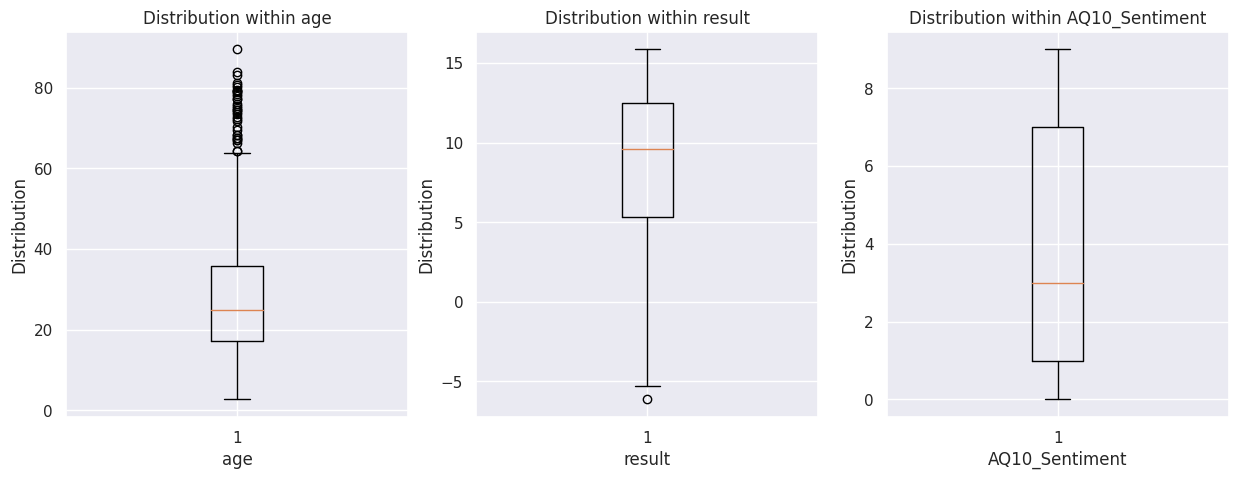

In [110]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_cols), figsize=(15, 5))

# Boxplot per feature
for i, feature in enumerate(numeric_cols):
    axes[i].boxplot(train_data[feature])
    axes[i].set_xlabel(feature)
    axes[i].set_title("Distribution within " + feature)
    axes[i].set_ylabel("Distribution")
plt.show()



*   Age:
  * This feature has a significant number of outliers, representing people of advanced age. We will use the median value, so that the shape of our feature isn't impacted by value replacement.
* result:
  * This feauture has a single outlier with a value far outside our IQR. This appears to be a true outlier, so we will replace its value with the median.
* AQ10_Sentiment:
  * This feature has no outliers to handle.





In [111]:
def outlier_replacement(column):
    #type 1 = IQR by default, else= median replacement
    # Get quartiles and IQR range
    Q1 = train_data[column].quantile(0.25)
    Q2 = train_data[column].quantile(0.50)
    Q3 = train_data[column].quantile(0.75)
    IQR = Q3 -Q1
    # Replace values with either medain or IQR min/max values
    # Replace outliers with median value
    train_data[column]= np.where(train_data[column]> (Q3 +1.5 * IQR), Q2, train_data[column])
    train_data[column] =np.where(train_data[column]< (Q1 -1.5 *IQR), Q2, train_data[column])


outlier_replacement("age")
outlier_replacement("result")

**Analysis on numeric features**

- Now that our data has been cleaned and all relavant categorical variables have been converted into binary features, lets preform analysis on our original numeric columns.

In [112]:
def get_aggregates(column):
    price_avg = np.mean(train_data[column])
    price_std = np.std(train_data[column])
    unique_count = len(train_data[column].unique())
    print("\n - " + column + ":")
    print("Mean: ", price_avg)
    print("Median: ", np.median(train_data[column]))
    print("Mode: ", stats.mode(train_data[column]))
    print("Standard Deviation: ", price_std)
    print("Unique values: " + str(unique_count))

for column in numeric_cols:
  get_aggregates(column)


 - age:
Mean:  26.282210552675
Median:  24.83767153
Mode:  24.848350449999998
Standard Deviation:  12.940644316626086
Unique values: 766

 - result:
Mean:  8.556981915696248
Median:  9.6088938215
Mode:  6.351165589
Standard Deviation:  4.776682471322038
Unique values: 800

 - AQ10_Sentiment:
Mean:  4.055
Median:  3.0
Mode:  0
Standard Deviation:  3.1771803537098737
Unique values: 10


-Lets visualize these distributions more thouroughly via histograms:

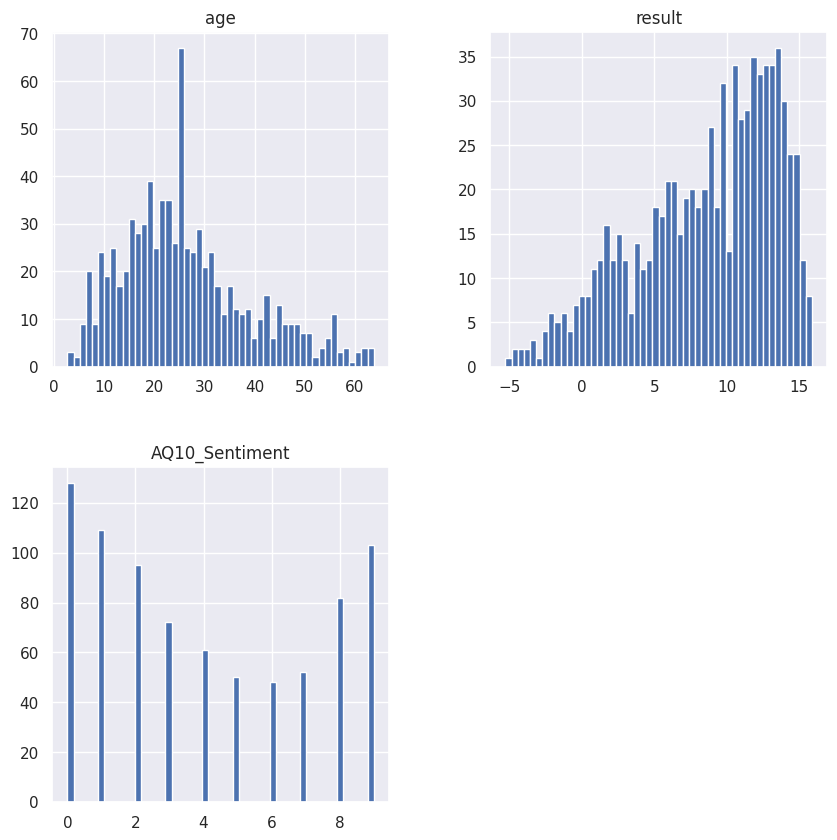

In [113]:
# Display the histograms of our numeric features:
train_data[numeric_cols].hist(bins=50, figsize=(10, 10))
plt.show()


*   Age:
  * This feature has a normal distribution, with a slight skew to the left. The median is higly represented within this feature due to the number of outliers that have been converted to the median value.
* result:
  * This feature has a significant skew to the right.
* AQ10_Sentiment:
  * This feature appears to be bimodal, with two distinct peaks on either side of their range.

## Linear Regression

- Create new column Difference_of_results (result - AQscore)

In [114]:
# Create the new columns:
new_col_name = 'difference_of_results'
train_data[new_col_name] = 0 # Ensures values aren't erroneously manipulated during cell execution
train_data[new_col_name] = train_data["result"] - train_data["AQ10_Sentiment"]
# Add new column to the numeric_cols list
numeric_cols.append(new_col_name)


- Lets determine the correlation between age and our three result variables:

In [115]:
result_cols = ['difference_of_results', "result", "AQ10_Sentiment"]
# Print the pearson coefficient for all three result variables against age
Y = train_data['age']
for col in result_cols:
  X = train_data[col]
  r, a = pearsonr(X, Y)

  print('Pearsons correlation between age and ' + col + ':\n %.3f' % r)

Pearsons correlation between age and difference_of_results:
 -0.275
Pearsons correlation between age and result:
 -0.171
Pearsons correlation between age and AQ10_Sentiment:
 0.103


In [116]:
Y = train_data['result']
for col in result_cols:
  X = train_data[col]
  r, a = pearsonr(X, Y)

  print('Pearson correlation between result and ' +col + ':\n %.3f' % r)

Pearson correlation between result and difference_of_results:
 0.756
Pearson correlation between result and result:
 1.000
Pearson correlation between result and AQ10_Sentiment:
 0.512


In [117]:
Y = train_data['AQ10_Sentiment']
for col in result_cols:
  X = train_data[col]
  r, a = pearsonr(X, Y)

  print('Pearson correlation between AQ10_Sentiment and ' +col + ':\n %.3f' % r)

Pearson correlation between AQ10_Sentiment and difference_of_results:
 -0.175
Pearson correlation between AQ10_Sentiment and result:
 0.512
Pearson correlation between AQ10_Sentiment and AQ10_Sentiment:
 1.000


In [118]:
Y = train_data['Class/ASD']
for col in result_cols:
  X = train_data[col]
  r, a = pearsonr(X, Y)

  print('Pearson correlation between Autism/No Autism Label and ' +col + ':\n %.3f' % r)

Pearson correlation between Autism/No Autism Label and difference_of_results:
 -0.052
Pearson correlation between Autism/No Autism Label and result:
 0.352
Pearson correlation between Autism/No Autism Label and AQ10_Sentiment:
 0.597


- It appears that the difference_of_results and result features both have a negative correlation to age, while AQ10_Sentiment has a slightly positive correlation.
- All three of these features show a weak correlation, indicating that the age of a patient and their result have little correlation.


In [119]:
r, a = pearsonr(train_data['AQ10_Sentiment'], train_data['result'])
print('Pearsons correlation between AQ10_Sentiment and result:')
print(r)

Pearsons correlation between AQ10_Sentiment and result:
0.5124571920198429


In [120]:
r, a = pearsonr(train_data['AQ10_Sentiment'], train_data['difference_of_results'])
print('Pearson correlation between AQ10_Sentiment and difference_of_results')
print(r)

Pearson correlation between AQ10_Sentiment and difference_of_results
-0.1750627658170929


In [121]:
r, a = pearsonr(train_data['difference_of_results'], train_data['result'])
print('Pearson correlation between difference of results and result')
print(r)

Pearson correlation between difference of results and result
0.7557397344167613


From the correlation measured for the AQ10_Sentiment and the result with respect to the difference of results label and found that there is a negative correlation between the AQ10_Sentiment column and difference of results and slight positive correlation between the difference of results column and the result column.

- The correlation between AQ10_Sentiment and the overall result is far higher when compared to other correlations seen, but lower than we would expect since the 10 variables that determine sentiment are supposed to be the most representative questions in the survey.
<br>

- Lets now visualize this correlation between our main numeric features:

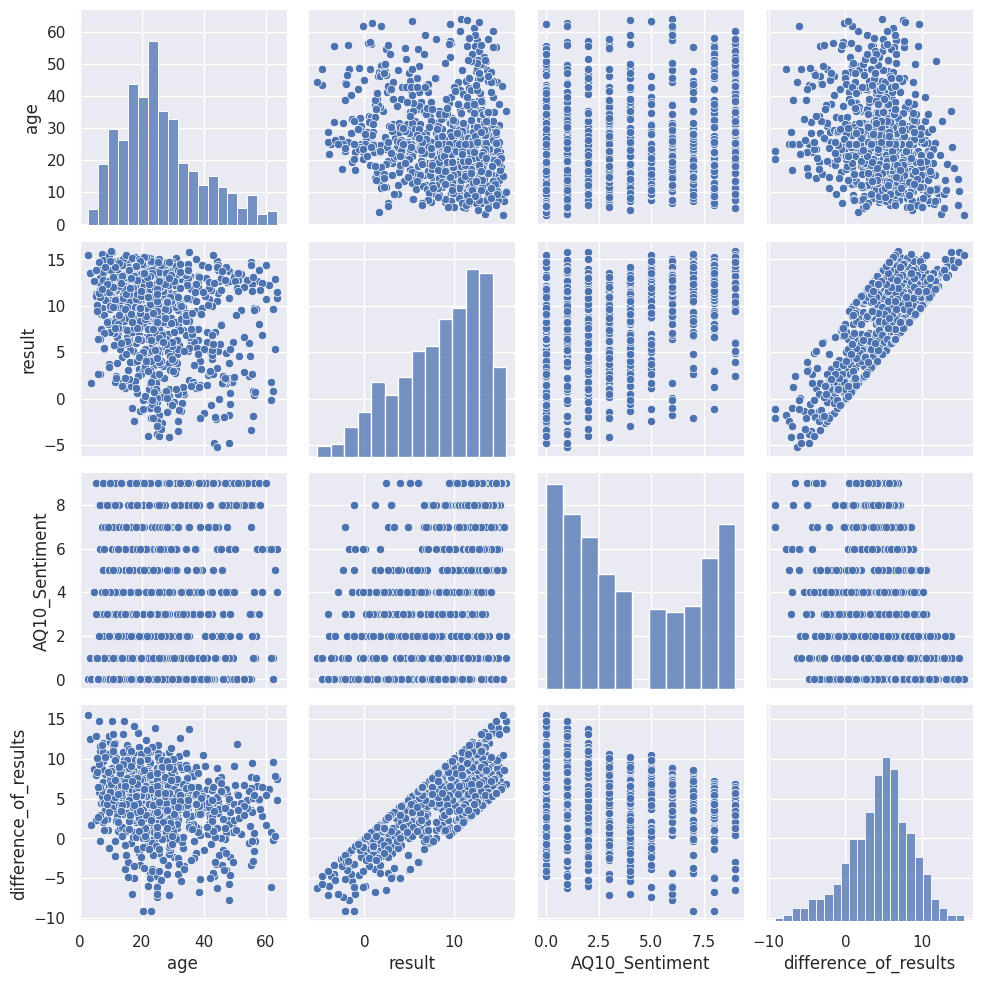

In [122]:
# Display the pair plots of our 4 numeric variables:
sns.set()
sns.pairplot(train_data[numeric_cols])

- Besides our derived feature compared to its ancestors, there visualizations show the poor correlation between numeric features.

- The AQ10 score column reprents the summation of positive sentiment on the questionaire.
- The result column is the weighted score based on the test answers.
- The difference_of_results is the distance between these two results.
- We first wish to see how a person's age affects this difference:


In [123]:
# Train a linear regression model
def run_lin_reg(X_column_names, y_col, is_single_variable):
    X = train_data[X_column_names]
    y = train_data[y_col]
    cols = ''
    if is_single_variable:
      cols = X.columns[0]
      X = np.array(X).reshape(-1,1)
    y = np.array(y).reshape(-1,1)
    model = sklearn.linear_model.LinearRegression()
    model.fit(X, y)
    r_sq = model.score(X, y)
    if not is_single_variable:
      for i, column in enumerate(X.columns):
          cols += column + ", "
      cols = cols[:-2]

    print("R-Squared: " + str(r_sq))
    print("Feature(s) evaluated: " + cols)
    print("\n")

print("Evaluating 'age':")
run_lin_reg(  ['AQ10_Sentiment'], ['age'], True)
run_lin_reg([ 'result'], ['age'], True)
run_lin_reg( [ 'difference_of_results'], ['age'], False)
run_lin_reg( [ 'difference_of_results', 'result'], ['age'], False)
run_lin_reg( [ 'difference_of_results', 'AQ10_Sentiment'], ['age'], False)
run_lin_reg( [ 'difference_of_results', 'AQ10_Sentiment','result', 'gender'], ['age'], False)

Evaluating 'age':
R-Squared: 0.01059665690441769
Feature(s) evaluated: AQ10_Sentiment


R-Squared: 0.02930863783733717
Feature(s) evaluated: result


R-Squared: 0.07551005051391568
Feature(s) evaluated: difference_of_results


R-Squared: 0.07861192566412267
Feature(s) evaluated: difference_of_results, result


R-Squared: 0.07861192566412256
Feature(s) evaluated: difference_of_results, AQ10_Sentiment


R-Squared: 0.07917912996215049
Feature(s) evaluated: difference_of_results, AQ10_Sentiment, result, gender




- The results of our above regression show that the age of a patient and the  results of the questionaire have a poor ability to predict age of a respondant.  
- It also shows that the difference_of_results is a far better predictor of age than the sentiment or result alone.
- Lets visualize this:

R-Squared: 0.07551005051391557


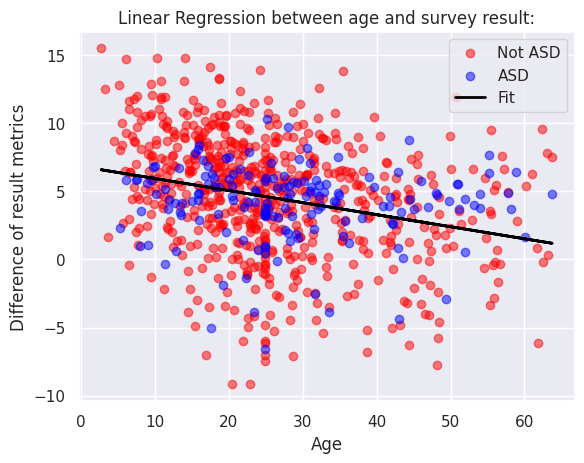

In [124]:
X = train_data['age']
X2 = np.array(X).reshape(-1, 1)
Y = train_data['difference_of_results']
Class_ASD_labels = train_data['Class/ASD']

model = LinearRegression()
model.fit(X2, Y)
r_sq = model.score(X2, Y)
print('R-Squared:', r_sq)
# Create a color map to show autism; black for no and blue for yes
colors = {0: 'red', 1: 'blue'}
color_map = [colors[label] for label in Class_ASD_labels]
plt.scatter(X2[Class_ASD_labels == 0], Y[Class_ASD_labels == 0], c='red', alpha=0.5, label='Not ASD')
plt.scatter(X2[Class_ASD_labels == 1], Y[Class_ASD_labels == 1], c='blue', alpha=0.5, label='ASD')

plt.plot(X2,model.predict(X2), label='Fit', color='black', linewidth=2)

plt.xlabel('Age')
plt.ylabel('Difference of result metrics')
plt.title('Linear Regression between age and survey result:')
plt.legend(loc='best')

plt.show()

- Lets next evaluate the relationship between the sentiment and test results:

R-Squared: 0.26261237365286216


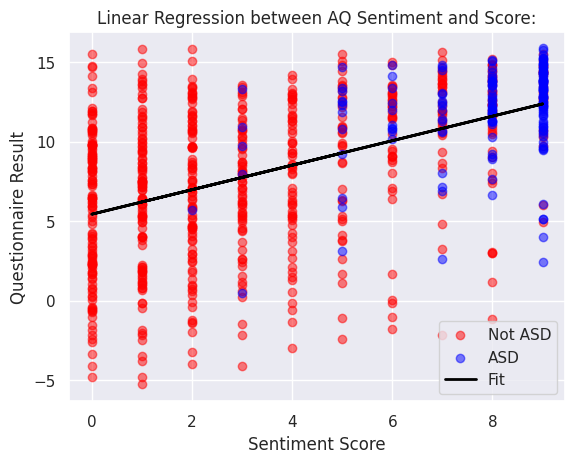

In [125]:

X = train_data['AQ10_Sentiment']
X2 = np.array(X).reshape(-1, 1)
Y = train_data['result']
Class_ASD_labels = train_data['Class/ASD']

model = LinearRegression()
model.fit(X2, Y)
r_sq = model.score(X2, Y)
print('R-Squared:', r_sq)
# Create a color map to show autism; black for no and blue for yes
colors = {0: 'red', 1: 'blue'}
color_map = [colors[label] for label in Class_ASD_labels]
plt.scatter(X2[Class_ASD_labels == 0], Y[Class_ASD_labels == 0], c='red', alpha=0.5, label='Not ASD')
plt.scatter(X2[Class_ASD_labels == 1], Y[Class_ASD_labels == 1], c='blue', alpha=0.5, label='ASD')
plt.plot(X2, model.predict(X2), label='Fit', color='black', linewidth=2)

plt.xlabel('Sentiment Score')
plt.ylabel('Questionnaire Result')
plt.title('Linear Regression between AQ Sentiment and Score:')
plt.legend(loc='best')

plt.show()

- Surprisingly, the AQ10_Sentiment is a fairly poor predictor of the overall test result, indicating the 10 chosen AQ questions aren't very good indicators of the test as a whole.
- Although the Sentiment, the intense concentration of blue points on the right side of the graph indicate that a high AQ sentiment score is a good indicator of having an ASD diagnosis.
- Lets preform linear regression on the result using the original ten binary columns represting answers to the AQ10 scores to see if we can find a better regressor:

In [126]:
# Fill X with the answers to the questions
scores = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']

print(scores)
run_lin_reg(scores, ['result'], False)

['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']
R-Squared: 0.2729037839291203
Feature(s) evaluated: A1_Score, A2_Score, A3_Score, A4_Score, A5_Score, A6_Score, A7_Score, A8_Score, A9_Score, A10_Score




- As individual features, the AQ scores return a slightly better R-squared value when predicting the overall result of the test. This indicates that the Sentiment isn't a good indicator of the
- Lets begin to include some of our converted categorical variables into our linear regression model:

In [127]:
converted_categorical = ['gender', 'jaundice', 'relative_has_autism', 'used_app_before','relation_direct', 'relation_health_professional', 'relation_others']
for i in range(len(converted_categorical)-2):
  temp = converted_categorical[i:]
  run_lin_reg(temp, ['result'], False)

R-Squared: 0.09580398571580562
Feature(s) evaluated: gender, jaundice, relative_has_autism, used_app_before, relation_direct, relation_health_professional, relation_others


R-Squared: 0.09491154351771403
Feature(s) evaluated: jaundice, relative_has_autism, used_app_before, relation_direct, relation_health_professional, relation_others


R-Squared: 0.0780959019757913
Feature(s) evaluated: relative_has_autism, used_app_before, relation_direct, relation_health_professional, relation_others


R-Squared: 0.008808029093456904
Feature(s) evaluated: used_app_before, relation_direct, relation_health_professional, relation_others


R-Squared: 0.0069540282272247955
Feature(s) evaluated: relation_direct, relation_health_professional, relation_others




- By themselves, these features are poor predictors of the result. By examining the resluts above, its easy to see that the variable jaundice has the largest impact of preformance.
- Lets redo this analyis, including our AQ sentimient and age to try and improve the outcome:

In [128]:
include_age = converted_categorical + ['age']
print("Including age:")
run_lin_reg(include_age, ['result'], False)
include_sentiment = converted_categorical + ["AQ10_Sentiment"]
print("Including AQ10_Sentiment:")
run_lin_reg(include_sentiment, ['result'], False)
print("Including both:")
include_both = converted_categorical + ["AQ10_Sentiment", 'age']
run_lin_reg(include_both, ['result'], False)
print("Including raw scores:")
include_scores = converted_categorical + scores + ['age']
run_lin_reg(include_scores, ['result'], False)

Including age:
R-Squared: 0.1260012007307384
Feature(s) evaluated: gender, jaundice, relative_has_autism, used_app_before, relation_direct, relation_health_professional, relation_others, age


Including AQ10_Sentiment:
R-Squared: 0.2668575176273503
Feature(s) evaluated: gender, jaundice, relative_has_autism, used_app_before, relation_direct, relation_health_professional, relation_others, AQ10_Sentiment


Including both:
R-Squared: 0.3162811073636501
Feature(s) evaluated: gender, jaundice, relative_has_autism, used_app_before, relation_direct, relation_health_professional, relation_others, AQ10_Sentiment, age


Including raw scores:
R-Squared: 0.32660483324804035
Feature(s) evaluated: gender, jaundice, relative_has_autism, used_app_before, relation_direct, relation_health_professional, relation_others, A1_Score, A2_Score, A3_Score, A4_Score, A5_Score, A6_Score, A7_Score, A8_Score, A9_Score, A10_Score, age




- Adding just the age feature resulted in little change to our model efficiency, AQ10_sentiment was a far better indicator as expected.
- These observations are in line with the peterson coefficents generated previously, with our Sentiment scores having the largest correlation to the survey result which is to be expected.
- The most effective prediction was made when we included all of our converted categorical variables and the raw sentiment scores.

**P3 Conclusion:** <br>
We preformed linear regression with our dataset for two purposes:
1. The first was to determine how the results of the different test metrics related to a survey respondants age. We found that all three metrics used, the survey's "result", "AQ10_Sentiment" scores, and the "difference_of_results" were poor predictors of a person's age. Interestingly, the difference_of_results metric was by far the best predictor of age.
2. Our second goal was to determine how effective our non-result numeric variables would be at predicting the result of the survey. Our Linear Regression model was a poor predictor, with an R-Squared value of 0.32 in the best case. Since this survey is supposed to indicate whether a person has autism, the ability to predict the test result from these features should mirror our ability to predict an ASD diagnosis through techniques we will use in P4. In the upcoming sections of this project we will determine through classification/clustering techniques how effective our features are at determining Autism, and then compare the effectiveness in order to evaluate how well the survey result indicates an autism diagnosis.

Difficulties:
- We had a small number of numeric variables to work with since our dataset is better suited for classification algorithms than for linear regression techniques. By creating dummy variables and converting qualitiative features to binary ones, we were able to increase the information passed into our linear regression model and slightly improve our results.

## Clustering:


**Agglomerative Clustering:**

- Lets begin our clustering with the bottom up Agglomerative Clustering method. We will examine a standard distance metric 'euclidean' and then a more complex metric 'gower'.


In [129]:
# Define final numerical cols:
numerical_col_list = converted_categorical + [ 'difference_of_results'] + ['age']
print(numerical_col_list)

['gender', 'jaundice', 'relative_has_autism', 'used_app_before', 'relation_direct', 'relation_health_professional', 'relation_others', 'difference_of_results', 'age']


- The euclidean metric groups samples by simple euclidean metric to form larger clusters.

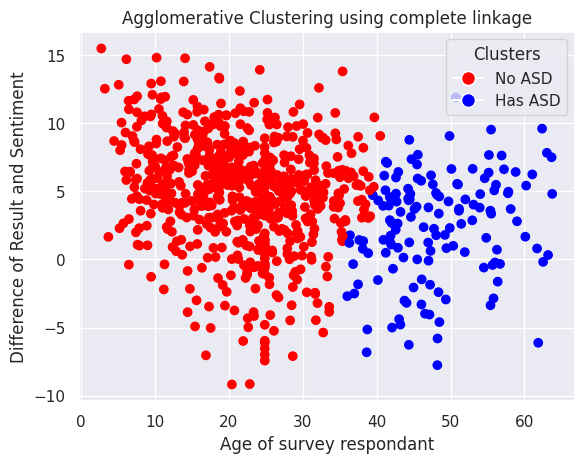

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       639
           1       0.25      0.22      0.23       161

    accuracy                           0.71       800
   macro avg       0.53      0.52      0.53       800
weighted avg       0.70      0.71      0.70       800



In [130]:
# Model creation
agg_model_complete = AgglomerativeClustering(n_clusters = 2, metric = 'euclidean', linkage = 'complete')
cluster_labels_complete = agg_model_complete.fit_predict(train_data[numerical_col_list])
#Plotting and formatting
cluster_colors_complete = ['red' if label == 0 else 'blue' for label in cluster_labels_complete]
plt.scatter(train_data['age'], train_data['difference_of_results'], c= cluster_colors_complete, label = ['No ASD', 'Has ASD'])
plt.xlabel('Age of survey respondant')
plt.ylabel('Difference of Result and Sentiment')
plt.title('Agglomerative Clustering using complete linkage')
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10)
                  for label, color in zip(['No ASD', 'Has ASD'], ['red', 'blue'])]

plt.legend(handles = legend_handles, title = 'Clusters')
plt.show()

# Show efficiency of clustering:
labels_actual = LabelEncoder().fit_transform(train_data['Class/ASD'])
labels_pred = LabelEncoder().fit_transform(cluster_labels_complete)

print(classification_report(labels_actual, labels_pred))

- The gower metric is used for mixed dataset with both continous and binary variables:

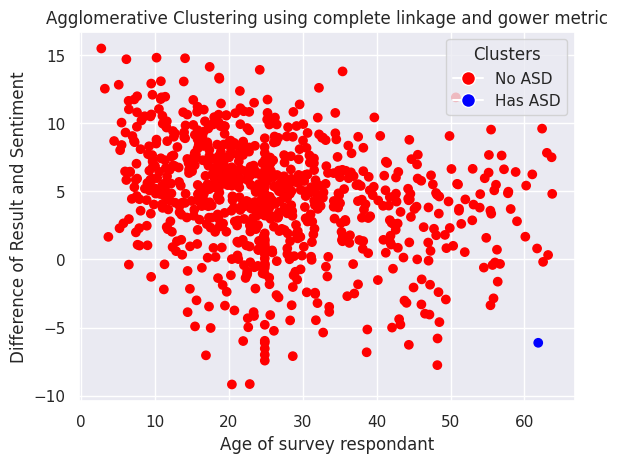

              precision    recall  f1-score   support

           0       0.80      1.00      0.89       639
           1       0.00      0.00      0.00       161

    accuracy                           0.80       800
   macro avg       0.40      0.50      0.44       800
weighted avg       0.64      0.80      0.71       800



In [131]:
gower_distance = pdist(train_data[numerical_col_list])
gower = squareform(gower_distance)
agg_model_gower = AgglomerativeClustering(n_clusters = 2, metric = 'precomputed', linkage = 'single')
cluster_labels_gower = agg_model_gower.fit_predict(gower)
cluster_colors_gower = ['red' if label == 0 else 'blue' for label in cluster_labels_gower]
plt.scatter(train_data['age'], train_data['difference_of_results'], c= cluster_colors_gower, label = ['No ASD', 'Has ASD'])
plt.xlabel('Age of survey respondant')
plt.ylabel('Difference of Result and Sentiment')
plt.title('Agglomerative Clustering using complete linkage and gower metric')
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10)
                  for label, color in zip(['No ASD', 'Has ASD'], ['red', 'blue'])]

plt.legend(handles = legend_handles, title = 'Clusters')
plt.show()

# Show efficiency of clustering:
labels_actual = LabelEncoder().fit_transform(train_data['Class/ASD'])
labels_pred = LabelEncoder().fit_transform(cluster_labels_gower)

print(classification_report(labels_actual, labels_pred))

- The gower metric works poorly despite its high accuracy. This is best shown by examining the f1 scores for both classes. Since there is such a high prevalence of 'No ASD' within our dataset, the accuracy is artificially inflated despite assigning almost all points to "No ASD" regardless of actual type.
- Both of these agglomerative clustering metrics work poorly with our dataset. The results of our linear regression indicated the numerical columns alone are poor predictors of the test result; and these results support that they alone are also poor predictors of Autism class.
- To improve this technique, lets try to undersample our 'No ASD' labels within our training dataset

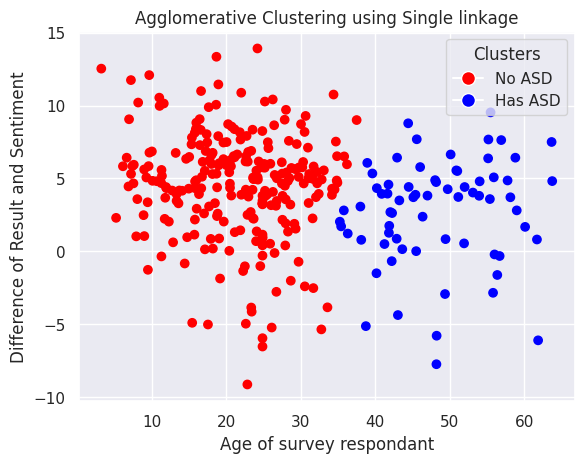

In [132]:
# Undersample our 'No ASD' entries:
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(train_data[numerical_col_list], train_data['Class/ASD'])

# Create a new DataFrame with the resampled data
df_balanced = pd.concat([pd.DataFrame(X_resampled, columns=train_data[numerical_col_list].columns), pd.DataFrame(y_resampled, columns=['Class/ASD'])], axis=1)

# Model creation
agg_model_bal = AgglomerativeClustering(n_clusters = 2, metric = 'manhattan', linkage = 'complete')
cluster_labels_bal = agg_model_bal.fit_predict(df_balanced[numerical_col_list])
#Plotting and formatting
cluster_colors_bal = ['red' if label == 0 else 'blue' for label in cluster_labels_bal]
plt.scatter(df_balanced['age'], df_balanced['difference_of_results'], c= cluster_colors_bal, label = ['No ASD', 'Has ASD'])
plt.xlabel('Age of survey respondant')
plt.ylabel('Difference of Result and Sentiment')
plt.title('Agglomerative Clustering using Single linkage')
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10)
                  for label, color in zip(['No ASD', 'Has ASD'], ['red', 'blue'])]

plt.legend(handles = legend_handles, title = 'Clusters')
plt.show()

# Show efficiency of clustering:
labels_actual = LabelEncoder().fit_transform(df_balanced['Class/ASD'])
labels_pred = LabelEncoder().fit_transform(cluster_labels_bal)


- Our best preforming 2-clustering was created using the undersampled dataset, balancing out the number of No ASD/ ASD samples.
- Although the accuracy is only 0.52, the f1-scores for each label from this clustering are significantly better than the previously seen results.  
- Lets now view the entropy for several different numbers of clusters and see if we can improve our model further using the balanced dataset:

For a clustering of 2:
0.6880013203432197
For a clustering of 12:
0.5792248632695595
For a clustering of 22:
0.4759721570426633
For a clustering of 32:
0.4143827612137276
For a clustering of 42:
0.38399063924553173
For a clustering of 52:
0.3776784717958103
For a clustering of 62:
0.32336415538067
For a clustering of 72:
0.30208771516208516
For a clustering of 82:
0.2801256667948148
For a clustering of 92:
0.2664552731130651


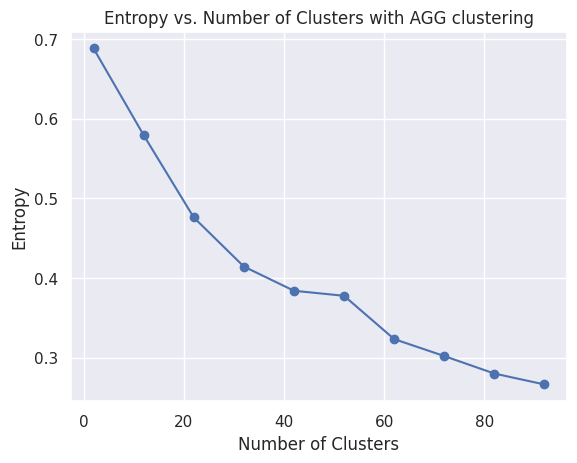

In [133]:
df_ent = df_balanced

def get_entropy(df, clusters=2, avg = False, plot = False):
    print('For a clustering of ' + str(clusters) + ':')
    cluster_entropy = []

    for i in range(len(list(df['Cluster'].unique()))):
        # for all clusters being analyzed
        cluster_points = df.loc[df['Cluster'] == i]
        cluster_labels = LabelEncoder().fit_transform(cluster_points['Class/ASD'])
        cluster_entropy.append(entropy(np.bincount(cluster_labels)))
    if avg == True:
      print(np.average(cluster_entropy))
    else:
      # Print entropy per clustre
      for i, ent in enumerate(cluster_entropy):
          print(f"Entropy of Cluster {i}: {ent}")
    return np.average(cluster_entropy)


# Call ent function with agg clustering
avg_entropies = []
c_range = list(range(2, 100, 10))
for i in c_range:
    agg_model_bal = AgglomerativeClustering(n_clusters=i, metric='manhattan', linkage='average')
    cluster_labels_bal = agg_model_bal.fit_predict(df_ent[numerical_col_list])

    # Update the 'Cluster' column in df_ent
    df_ent['Cluster'] = cluster_labels_bal

    # Call the get_entropy function
    avg_entropies.append(get_entropy(df_ent, i, avg = True))

def plot_entropy(entropies, c_range, model_type):
  plt.plot(c_range, entropies, marker='o', linestyle='-')
  plt.xlabel('Number of Clusters')
  plt.ylabel('Entropy')
  plt.title('Entropy vs. Number of Clusters ' + model_type)
  plt.grid(True)
  plt.show()

plot_entropy(avg_entropies, c_range, "with AGG clustering")

**K-Means Clustering:**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


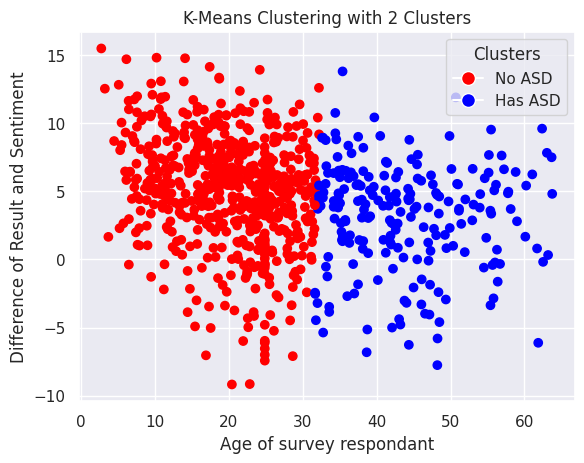

              precision    recall  f1-score   support

           0       0.82      0.75      0.78       639
           1       0.25      0.33      0.28       161

    accuracy                           0.66       800
   macro avg       0.53      0.54      0.53       800
weighted avg       0.70      0.66      0.68       800



In [134]:
# Create a KMeans model with 2 clusters
kmeans = KMeans(n_clusters=2)

# Fit the model to the data
cluster_labels_kmeans = kmeans.fit_predict(train_data[numerical_col_list])


#Plotting and formatting
cluster_colors_single = ['red' if label == 0 else 'blue' for label in cluster_labels_kmeans]

# Plot the data points with different colors for each cluster
plt.scatter(train_data['age'], train_data['difference_of_results'], c= cluster_colors_single, label = ['No ASD', 'Has ASD'])
plt.xlabel('Age of survey respondant')
plt.ylabel('Difference of Result and Sentiment')
plt.title('K-Means Clustering with 2 Clusters')
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10)
                  for label, color in zip(['No ASD', 'Has ASD'], ['red', 'blue'])]
plt.legend(handles = legend_handles, title = 'Clusters')
plt.show()


# Show efficiency of clustering:
labels_actual = LabelEncoder().fit_transform(train_data['Class/ASD'])
labels_pred = LabelEncoder().fit_transform(cluster_labels_kmeans)

print(classification_report(labels_actual, labels_pred))

- Due to the overlapping densities of our data, K-Means doesn't appear to be a very good clustering algorithm for our dataset.

**Mini Batch K-Means Clustering:**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


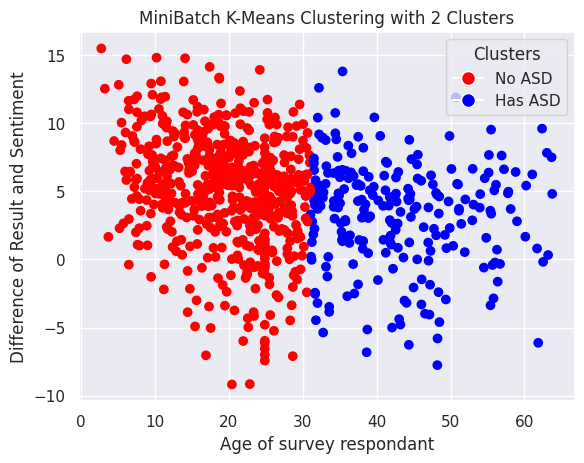

              precision    recall  f1-score   support

           0       0.82      0.73      0.77       639
           1       0.25      0.35      0.29       161

    accuracy                           0.65       800
   macro avg       0.53      0.54      0.53       800
weighted avg       0.70      0.65      0.67       800



In [135]:
# Create a MiniBatchKMeans model with 2 clusters
minibatch_kmeans = MiniBatchKMeans(n_clusters=2)

# Fit the model to the data
cluster_labels_mbk = minibatch_kmeans.fit_predict(train_data[numerical_col_list])

#Plotting and formatting
cluster_colors_single = ['red' if label == 0 else 'blue' for label in cluster_labels_mbk]

# Plot the data points with different colors for each cluster
plt.scatter(train_data['age'], train_data['difference_of_results'], c= cluster_colors_single, label = ['No ASD', 'Has ASD'])
plt.xlabel('Age of survey respondant')
plt.ylabel('Difference of Result and Sentiment')
plt.title('MiniBatch K-Means Clustering with 2 Clusters')
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10)
                  for label, color in zip(['No ASD', 'Has ASD'], ['red', 'blue'])]
plt.legend(handles = legend_handles, title = 'Clusters')
plt.show()


# Show efficiency of clustering:
labels_actual = LabelEncoder().fit_transform(train_data['Class/ASD'])
labels_pred = LabelEncoder().fit_transform(cluster_labels_mbk)

print(classification_report(labels_actual, labels_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


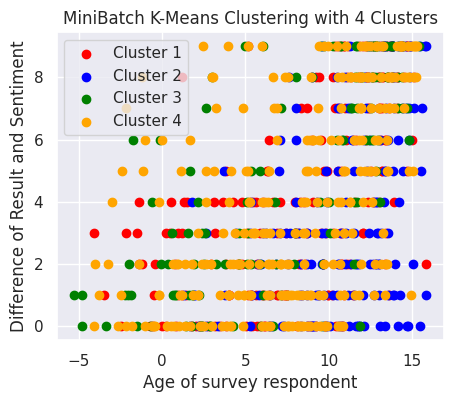

              precision    recall  f1-score   support

           0       0.76      0.24      0.36       639
           1       0.16      0.19      0.17       161
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.23       800
   macro avg       0.23      0.11      0.13       800
weighted avg       0.64      0.23      0.32       800



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [136]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=4, random_state=42)
cluster_label_predict = minibatch_kmeans.fit_predict(train_data[numerical_col_list])
cluster_centers = minibatch_kmeans.cluster_centers_

colors = ['red', 'blue', 'green', 'orange']

plt.figure(figsize=(5, 4))
for i in range(4):
  cluster_points = train_data[cluster_label_predict == i]
  plt.scatter(cluster_points['result'], cluster_points['AQ10_Sentiment'], label=f'Cluster {i+1}', c=colors[i])

plt.xlabel('Age of survey respondent')
plt.ylabel('Difference of Result and Sentiment')
plt.title('MiniBatch K-Means Clustering with 4 Clusters')
plt.legend()
plt.show()

labels_actual = LabelEncoder().fit_transform(train_data['Class/ASD'])
labels_pred = LabelEncoder().fit_transform(cluster_label_predict)

print(classification_report(labels_actual, labels_pred))

In [137]:
def compute_cluster_distribution(labels, n_clusters):
  cluster_dist = np.zeros(n_clusters)
  total_samples = len(labels)

  for label in labels:
    cluster_dist[label] += 1

  cluster_dist /= total_samples

  return cluster_dist

def compute_entropy(cluster_dist):
  entropy = -np.sum(cluster_dist * np.log2(cluster_dist + 1e-10))
  return entropy

minibatch_kmeans = MiniBatchKMeans(n_clusters=4, random_state=42)
cluster_label_predict = minibatch_kmeans.fit_predict(train_data[numerical_col_list])

cluster_distribution = compute_cluster_distribution(cluster_label_predict, n_clusters=10)
entropy = compute_entropy(cluster_distribution)
print("Entropy:", entropy)

Entropy: 1.9414408515737844


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


* Mini-Batch K-Means:
    * Our dataset is relatively large, so mini-batch k-means is a good option.
    * Our dataset contains both spherical and non-spherical clusters, so mini-batch k-means may not be the best choice.

**Mean-Shift Clustering:**

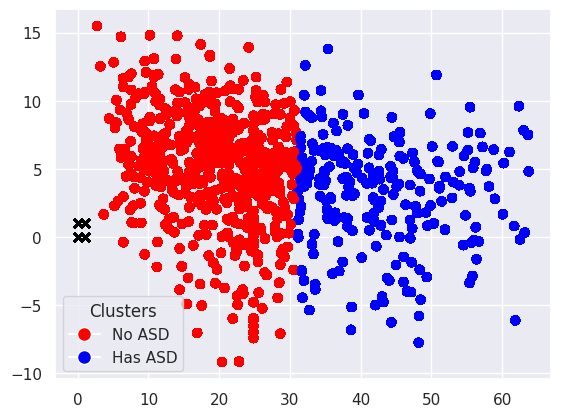

In [138]:
# Create a MeanShift object with the desired bandwidth
bandwidth = 0.5
ms = MeanShift(bandwidth=bandwidth)

# Fit the model to the data
cluster_labels_meanshift = ms.fit_predict(train_data[numerical_col_list])

# Get the cluster centers
cluster_centers = ms.cluster_centers_

#Plotting and formatting
cluster_colors_single = ['red' if label == 0 else 'blue' for label in cluster_labels_mbk]


# Plot the data points with different colors for each cluster
for i in range(len(cluster_colors_single)):
    plt.scatter(train_data['age'], train_data['difference_of_results'], c=cluster_colors_single, label = ['No ASD', 'Has ASD'])


# Plot the cluster centers
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', color='black')

#legends
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10)
                  for label, color in zip(['No ASD', 'Has ASD'], ['red', 'blue'])]
plt.legend(handles = legend_handles, title = 'Clusters')

# Show the plot
plt.show()




* Mean Shift:
    * Our dataset is relatively large, so mean shift may be slow.
    * Our dataset contains both spherical and non-spherical clusters, so mean shift is a good option.

Overall, mean shift is the best clustering method for our dataset. It is robust to outliers, can find non-spherical clusters, and can be used for high-dimensional data. However, it is important to note that mean shift can be slow for large datasets and computationally expensive


## Classification:

**K-Nearest Neighbors:**
- Lets find an optimal K value for our classifier:

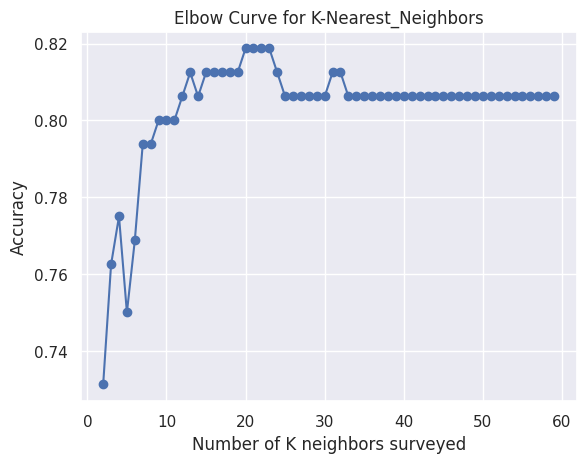

In [139]:
X_train, X_test, y_train, y_test = train_test_split(train_data[numerical_col_list], train_data['Class/ASD'], test_size=0.2, random_state=0)
k_values = range(2,60)
accuracy_scores = []
for k in k_values:
  knn_temp = KNeighborsClassifier(n_neighbors=k, weights = 'distance')
  knn_temp.fit(X_train, y_train)
  y_pred = knn_temp.predict(X_test)
  accuracy_scores.append(accuracy_score(y_test, y_pred))

plt.plot(k_values, accuracy_scores, marker = 'o')
plt.title('Elbow Curve for K-Nearest_Neighbors')
plt.xlabel('Number of K neighbors surveyed')
plt.ylabel('Accuracy')
plt.show()

- The accuracy metric appears to be a poor indicator of classifiation success. From the results of our clustering, we can determine that this is due to the uneven distribution of our ASD class labels.
- Lets try to improve this by using the balanced dataset created during clustering:

- Although the curve created resembles what we would expect from a typical elbow curve, the spikes in this curve indicate there is a high noise in our datset.
- Lets try to use f1-score as our metric instead; we will use the mean f1-score of both class labels:

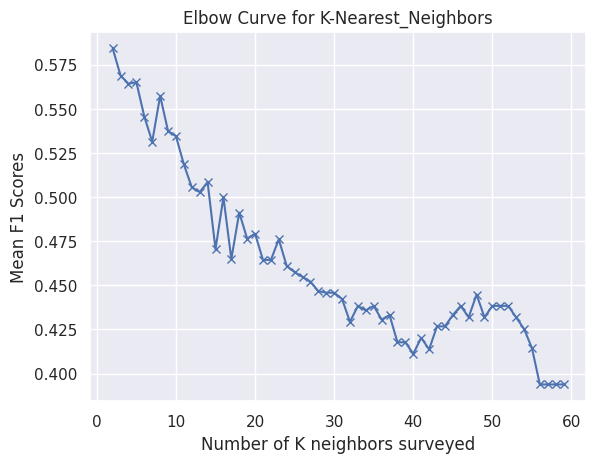

In [140]:
X_train, X_test, y_train, y_test = train_test_split(df_balanced[numerical_col_list], df_balanced['Class/ASD'], test_size=0.8, random_state=0)
f1_scores = []
for k in k_values:
  knn_temp = KNeighborsClassifier(n_neighbors=k, weights = 'distance')
  knn_temp.fit(X_train, y_train)
  y_pred = knn_temp.predict(X_test)
  f1_0 = f1_score(y_test, y_pred, pos_label=0)
  f1_1 = f1_score(y_test, y_pred, pos_label=1)
  f1_scores.append(np.mean([f1_0,f1_1]))

plt.plot(k_values, f1_scores, marker = 'x')
plt.title('Elbow Curve for K-Nearest_Neighbors')
plt.xlabel('Number of K neighbors surveyed')
plt.ylabel('Mean F1 Scores')
plt.show()

- Using the results of the two graphs, a k value of 20 seems to be the best choice. It results in the highest accuracy in the normal dataset, and appears to be the point of the first elbow within the curve.

In [141]:
# Save best K and print metrics:
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(df_balanced[numerical_col_list], df_balanced['Class/ASD'], test_size=0.4, random_state=0)
knn_best = KNeighborsClassifier(n_neighbors=20, weights = 'distance')
knn_best.fit(X_train, y_train)
y_pred = knn_temp.predict(X_test_bal)
print(classification_report(y_test_bal,y_pred))
# Save fpr/tpr/auc for final classification comparisons:
y_pred = knn_temp.predict(X_test_bal)
fpr, tpr, thresholds = roc_curve(y_test_bal, y_pred)
roc_auc = auc(fpr, tpr)
KNN_roc = [roc_auc, fpr, tpr]

# Lets us cross validation
cv_scores = cross_val_score(knn_best, df_balanced[numerical_col_list], df_balanced['Class/ASD'], cv=10, scoring='f1_weighted')
print('Results of CV scores, using mean f1 score as metric: \n', cv_scores)

              precision    recall  f1-score   support

           0       0.62      0.07      0.13        67
           1       0.49      0.95      0.64        62

    accuracy                           0.50       129
   macro avg       0.56      0.51      0.39       129
weighted avg       0.56      0.50      0.38       129

Results of CV scores, using mean f1 score as metric: 
 [0.57497772 0.51245791 0.49206349 0.71625616 0.62352941 0.53333333
 0.71847507 0.75       0.55555556 0.32732733]


- The cross validation scores for this model have a high variance, indicating that the model isn't generalizing very well to our data.
- The large variance in our cross validation scores and the noise depicted in our elbow curve show that this model is a poor choice for our dataset.

**Logistic Regression:**
- Our dataset has a large number of catagorical variables and dummy variables. Due to this, an algorithm that makes use of these features should preform better than our KNN results.
- We will first run the regression on the balanced dataset using the same feature set used during KNN:

In [142]:
def train_log_regression(X,y, c = None, plot = False):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

  if c != None:
    clf = LogisticRegression(max_iter=10000, C = c, random_state = 4)
  else:
    clf = LogisticRegression(max_iter=10000)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  conf_matrix = confusion_matrix(y_test, y_pred)
  print('Confusion Matrix:')
  print(conf_matrix)
  print(classification_report(y_test, y_pred))

  cv_scores = cross_val_score(clf, X, y, cv=5)
  print("Cross Validation Scores:", cv_scores)
  print("Mean Cross Validation Scores:", cv_scores.mean())

  # Get false positive and true positive rate and generate the area under the curve:
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  roc_auc = auc(fpr, tpr)
  return [roc_auc, fpr, tpr]
balanced_log_auc = train_log_regression(df_balanced[numerical_col_list], df_balanced['Class/ASD'], c = 100)

Confusion Matrix:
[[35 12]
 [23 27]]
              precision    recall  f1-score   support

           0       0.60      0.74      0.67        47
           1       0.69      0.54      0.61        50

    accuracy                           0.64        97
   macro avg       0.65      0.64      0.64        97
weighted avg       0.65      0.64      0.64        97

Cross Validation Scores: [0.63076923 0.69230769 0.625      0.671875   0.609375  ]
Mean Cross Validation Scores: 0.6458653846153846


- These results already improve upon our KNN model results.
- Lets add all categorical features that couldn't be included in a numerical-based model and see the results:

In [143]:
categorical_features = list(train_data.select_dtypes(include=['object']).columns)
drop_features = categorical_features + ['Class/ASD']

full_set_log_auc = train_log_regression(train_data.drop(columns = drop_features), train_data['Class/ASD'], c = 1)

Confusion Matrix:
[[174  12]
 [ 19  35]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       186
           1       0.74      0.65      0.69        54

    accuracy                           0.87       240
   macro avg       0.82      0.79      0.81       240
weighted avg       0.87      0.87      0.87       240

Cross Validation Scores: [0.8125  0.84375 0.9     0.8625  0.88125]
Mean Cross Validation Scores: 0.86


- This drastically increases both f1 scores of both labels AND the total accuracy.
- Lets now use cross validation to find an optimal C parameter for our regression model:

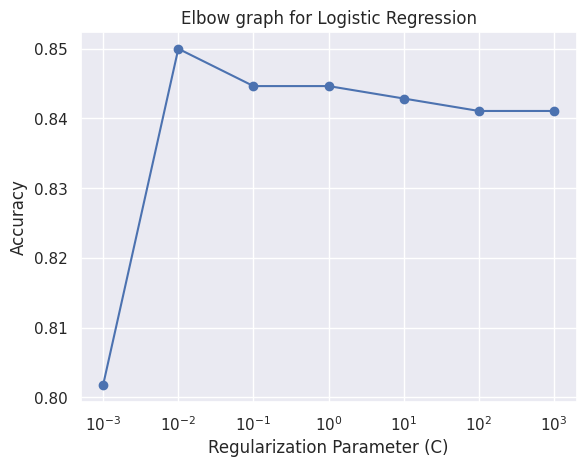

In [144]:
X_train, X_test, y_train, y_test = train_test_split(train_data.drop(columns = drop_features), train_data['Class/ASD'], test_size=0.3, random_state=0)
# Lets apply cross validation to find optimal logistic regression model for our dataset
C_values = np.logspace(-3, 3, 7)
accuracy_scores = []

for C in C_values:
  clf = LogisticRegression(C=C, max_iter=10000, random_state = 4)
  clf.fit(train_data.drop(columns = drop_features), train_data['Class/ASD'])
  cv_scores = cross_val_score(clf, X_train, y_train, cv=10)
  accuracy_scores.append(np.mean(cv_scores))

plt.plot(C_values, accuracy_scores, marker = 'o')
plt.xscale('log')
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Accuracy')
plt.title('Elbow graph for Logistic Regression')
plt.grid(True)
plt.show()

- The best model is created using a C of 0.01. Lets visualize the model's preformance using this hyperparameter:




In [145]:
best_C_log_AUC = train_log_regression(train_data.drop(columns = drop_features), train_data['Class/ASD'], c = 0.100, plot = False)

Confusion Matrix:
[[177   9]
 [ 20  34]]
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       186
           1       0.79      0.63      0.70        54

    accuracy                           0.88       240
   macro avg       0.84      0.79      0.81       240
weighted avg       0.87      0.88      0.87       240

Cross Validation Scores: [0.825   0.84375 0.90625 0.8625  0.875  ]
Mean Cross Validation Scores: 0.8625


- This model has slightly higher accuracy, and preforms better in our f1 scores. Lets view a Receiver Operationg characteristic Curve to determine the best model:

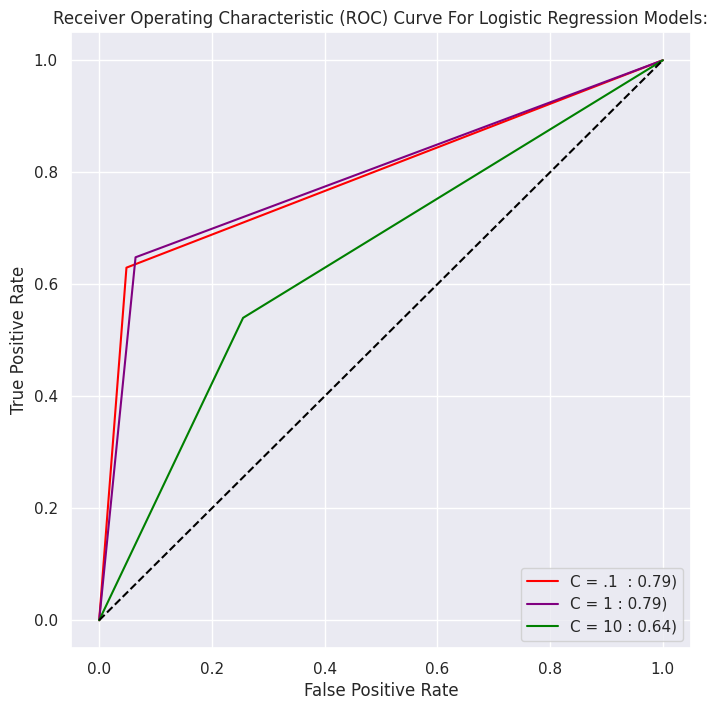

In [146]:
# Plot ROC Curve
plt.figure(figsize=(8, 8))
plt.plot(best_C_log_AUC[1], best_C_log_AUC[2], color='red', label=f'C = .1  : {best_C_log_AUC[0]:.2f})')
plt.plot(full_set_log_auc[1], full_set_log_auc[2], color='purple', label=f'C = 1 : {full_set_log_auc[0]:.2f})')
plt.plot(balanced_log_auc[1], balanced_log_auc[2], color='green', label=f'C = 10 : {balanced_log_auc[0]:.2f})')

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve For Logistic Regression Models:')
plt.legend(loc='lower right')
plt.show()

- The best regression model used a C = 0.01. Altough a C value of 1 creates a similar ROC curve, the smaller C value should help ensure the model isn't overfitting our data.

**Support Vector Machine for Classification:**
- Lets examine a more complicated model that can make good use of our categorical variables. We will start with a basic linear kernel:

In [147]:
def print_svm_kernel_suite(X_train_bal, X_test_bal, y_train_bal, y_test_bal):
    clf_linear = SVC(kernel = 'linear', C=1.0).fit(X_train_bal, y_train_bal)
    y_pred_linear = clf_linear.predict(X_test_bal)
    result_metrics_linear = classification_report(y_test_bal, y_pred_linear)
    print('Linear Kernel results: \n', result_metrics_linear)

    clf_rbf = SVC(kernel = 'poly', max_iter=10000, degree = 3).fit(X_train_bal, y_train_bal)
    y_pred_poly = clf_rbf.predict(X_test_bal)
    result_metrics_poly = classification_report(y_test_bal, y_pred_poly)
    print('Polynomial Kernel results: \n', result_metrics_poly)

    #RBF is default and doesn't need explicit assignment as a parameter
    clf_rbf = SVC(kernel = 'rbf', max_iter=10000).fit(X_train_bal, y_train_bal)
    y_pred_rbf = clf_rbf.predict(X_test_bal)
    result_metrics_rbf = classification_report(y_test_bal, y_pred_rbf)
    print('RBF Kernel results: \n',result_metrics_rbf)
print_svm_kernel_suite(X_train_bal, X_test_bal, y_train_bal, y_test_bal)

Linear Kernel results: 
               precision    recall  f1-score   support

           0       0.64      0.63      0.63        67
           1       0.60      0.61      0.61        62

    accuracy                           0.62       129
   macro avg       0.62      0.62      0.62       129
weighted avg       0.62      0.62      0.62       129

Polynomial Kernel results: 
               precision    recall  f1-score   support

           0       1.00      0.03      0.06        67
           1       0.49      1.00      0.66        62

    accuracy                           0.50       129
   macro avg       0.74      0.51      0.36       129
weighted avg       0.75      0.50      0.35       129

RBF Kernel results: 
               precision    recall  f1-score   support

           0       0.55      0.42      0.47        67
           1       0.50      0.63      0.56        62

    accuracy                           0.52       129
   macro avg       0.52      0.52      0.52       12

- The linear kernel preforms better than our KNN model, but worse than all logistic regression models.  Lets try these models again on the full training set, adding encoded categorical variables to the model and see if this improves our results:

In [148]:
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(train_data.drop(columns = drop_features), train_data['Class/ASD'], test_size=0.2, random_state=0)

print_svm_kernel_suite(X_train_enc, X_test_enc, y_train_enc, y_test_enc)


clf_linear = SVC(kernel = 'linear', C=1.0).fit(X_train_enc, y_train_enc)
# Save fpr/tpr/auc for final classification comparisons:
y_pred = clf_linear.predict(X_test_enc)
fpr, tpr, thresholds = roc_curve(y_test_enc, y_pred)
roc_auc = auc(fpr, tpr)
SVC_linear_roc = [roc_auc, fpr, tpr]

Linear Kernel results: 
               precision    recall  f1-score   support

           0       0.96      0.91      0.93       129
           1       0.68      0.84      0.75        31

    accuracy                           0.89       160
   macro avg       0.82      0.87      0.84       160
weighted avg       0.91      0.89      0.90       160

Polynomial Kernel results: 
               precision    recall  f1-score   support

           0       0.88      0.95      0.91       129
           1       0.67      0.45      0.54        31

    accuracy                           0.85       160
   macro avg       0.77      0.70      0.72       160
weighted avg       0.84      0.85      0.84       160

RBF Kernel results: 
               precision    recall  f1-score   support

           0       0.91      0.92      0.92       129
           1       0.66      0.61      0.63        31

    accuracy                           0.86       160
   macro avg       0.78      0.77      0.77       16

- Using all of our encoded categorical variables causes our models to  preform far better.
- The Linear kernel stil out-preforms the more complex kernels. Lets try to change hyperparameters in our rbf kernel and see if it helps:


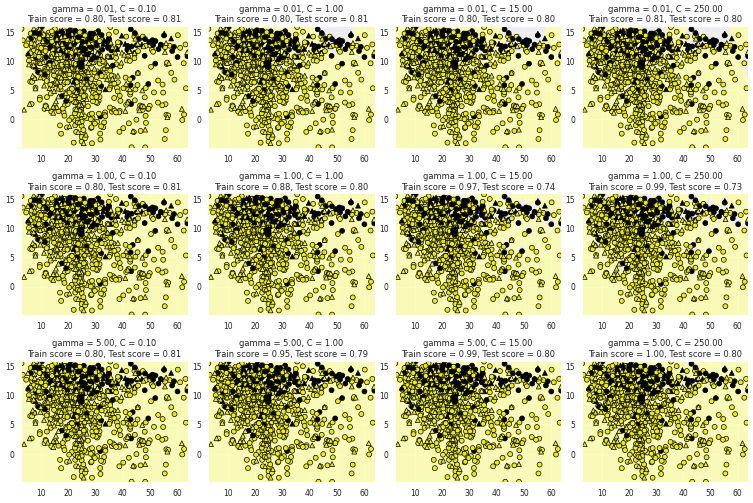

In [92]:
# Support code provided by professor for SVC plotting
# This cell will take roughly 6-8 minutes to run because of the high number of features
def plot_class_regions_for_classifier_subplot(clf, X, y, X_test, y_test, title, subplot, target_names = None, plot_decision_regions = True):

    numClasses = np.amax(y) + 1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses])

    h = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50

    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()
    x2, y2 = np.meshgrid(np.arange(x_min-k, x_max+k, h), np.arange(y_min-k, y_max+k, h))

    P = clf.predict(np.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)

    if plot_decision_regions:
        subplot.contourf(x2, y2, P, cmap=cmap_light, alpha = 0.8)

    subplot.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    subplot.set_xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    subplot.set_ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)

    if (X_test is not None):
        subplot.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    subplot.set_title(title)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        subplot.legend(loc=0, handles=legend_handles)

X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(np.array(train_data[['age','result']]), np.array(train_data['Class/ASD']), test_size=0.2, random_state=0)

fig, subaxes = plt.subplots(3, 4, figsize=(15, 10), dpi=50)

for this_gamma, this_axis in zip([0.01, 1, 5], subaxes):

    for this_C, subplot in zip([0.1, 1, 15, 250], this_axis):
        title = 'gamma = {:.2f}, C = {:.2f}'.format(this_gamma, this_C)
        clf = SVC(kernel = 'rbf', gamma = this_gamma,
                 C = this_C).fit(X_train_sub, y_train_sub)
        plot_class_regions_for_classifier_subplot(clf, X_train_sub, y_train_sub,
                                                 X_test_sub, y_test_sub, title,
                                                 subplot)
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

- The best preforming RBF kernel used a gamma of 5.00 and a C value of 15. This still preforms worse than our linear kernel SVC, so we will keep the linear kernel as choice for this classification type.

In [93]:
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(train_data.drop(columns = drop_features), train_data['Class/ASD'], test_size=0.2, random_state=0)

#RBF is default and doesn't need explicit assignment as a parameter
clf_rbf = SVC(kernel = 'rbf', max_iter=10000, C = 15, gamma = 5).fit(X_train_enc, y_train_enc)
y_pred_rbf = clf_rbf.predict(X_test_enc)
fpr, tpr, thresholds = roc_curve(y_test_enc, y_pred_rbf)
roc_auc = auc(fpr, tpr)
SVC_RBF_roc = [roc_auc, fpr, tpr]
result_metrics_rbf = classification_report(y_test_enc, y_pred_rbf)
print('Using gamma = 5 and C = 15 with RBF kernel:')
print(result_metrics_rbf)


Using gamma = 5 and C = 15 with RBF kernel:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90       129
           1       1.00      0.03      0.06        31

    accuracy                           0.81       160
   macro avg       0.91      0.52      0.48       160
weighted avg       0.85      0.81      0.73       160



**Receiver Operator Characteristic Curve:**

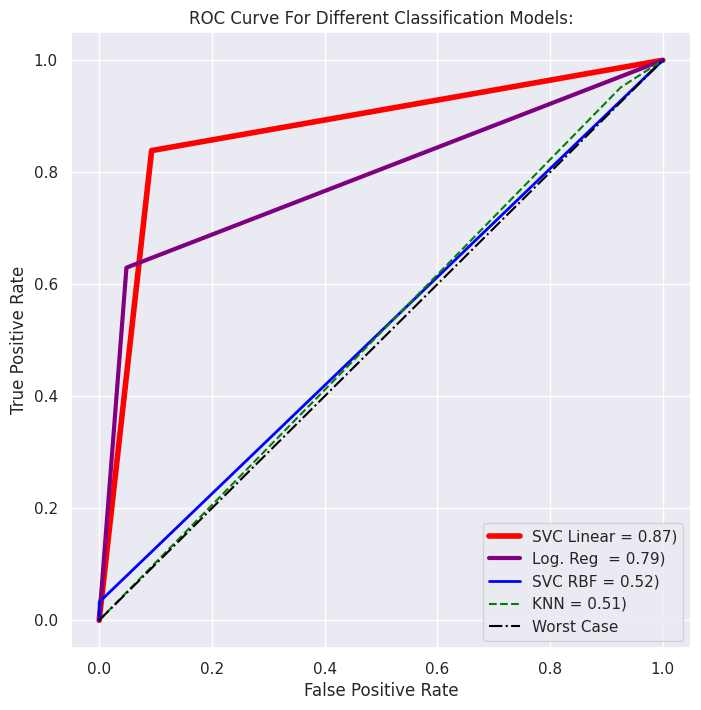

In [94]:
# Plot ROC Curve to visualize efficiency of different classification algorithms
plt.figure(figsize=(8, 8))
plt.plot(SVC_linear_roc[1], SVC_linear_roc[2], color='red', lw = 4, label=f'SVC Linear = {SVC_linear_roc[0]:.2f})')
plt.plot(best_C_log_AUC[1], best_C_log_AUC[2], color='purple', lw = 3, label=f'Log. Reg  = {best_C_log_AUC[0]:.2f})')
plt.plot(SVC_RBF_roc[1], SVC_RBF_roc[2], color='blue', lw = 2, label=f'SVC RBF = {SVC_RBF_roc[0]:.2f})')
plt.plot(KNN_roc[1], KNN_roc[2], color='green', linestyle='--', label=f'KNN = {KNN_roc[0]:.2f})')

plt.plot([0, 1], [0, 1], color='black', label = 'Worst Case', linestyle='-.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve For Different Classification Models:')
plt.legend(loc='lower right')
plt.show()

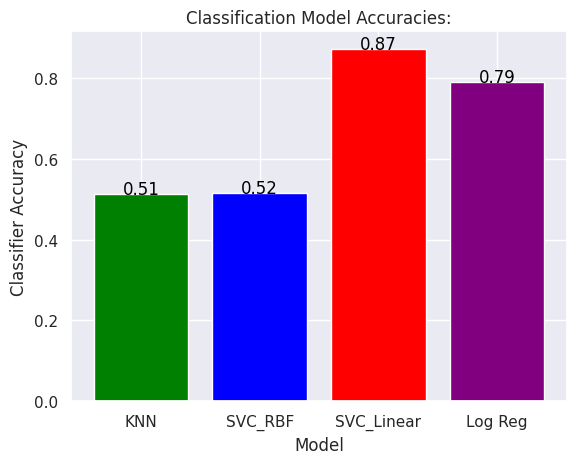

In [95]:
models = ['KNN', 'SVC_RBF', 'SVC_Linear', 'Log Reg']
acc = [KNN_roc[0], SVC_RBF_roc[0],SVC_linear_roc[0], best_C_log_AUC[0]]
plt.bar(models, acc, color = ['green', 'blue', 'red', 'purple'])
plt.title("Classification Model Accuracies:")
plt.xlabel("Model")
plt.ylabel('Classifier Accuracy')
for i, v in enumerate(acc):
    plt.text(i, v  , str(round(v, 2)), ha='center', color='black')
plt.show()

**P4 Conclusions:**
- Our best classification model was the Support Vector Machine for Classification (SVC) using a linear kernel. We believe this is due to the RBF model overfitting the No ASD label. Since there is such an imbalance in our dataset, the RBF kernel using the full training dataset preformed poorly, and we had to use a equally distributed amount
- Both linear SVC and the Logistic Regression models benefitted from the linear nature of our dataset's features, specifically the numerical columns representing the result of the AQ50 test, and its sentiment.
- We believe the KNN model worked poorly due to density of our data; many of our points overlap regardless of class label, and so the representation of 'closeness', especially using the numerical features alone, proved to be a poor predictor even when using a weighted distance metric.